## Comparing ICESat-2 Altimetry Elevations with DEM
### Example Notebook
This notebook compares elevations from ICESat-2 to those from a DEM.

#### Credits
* notebook by: Jessica Scheick and Shashank Bhushan


### Import packages, including icepyx

In [2]:
from icepyx import is2class as ipd
import os
import shutil

### Create an ICESat-2 data object with the desired search parameters
See the ICESat-2 DAAC Data Access notebook for more details on downloading data from the NSIDC

In [3]:
region_a = ipd.Icesat2Data('ATL08', [-73.9, 10.7, -73.4, 11.1], ['2018-12-01','2019-09-01'], \
                          start_time='00:00:00', end_time='23:59:59')

### Finding and downloading data
In order to download any data from NSIDC, we must first authenticate ourselves using a valid Earthdata login. This will create a valid token to interface with the DAAC as well as start an active logged-in session to enable data download. The token is attached to the data object and stored, but the session must be passed to the download function. Then we can order the granules.

#### Log in to Earthdata

In [4]:
earthdata_uid = 'jessica.scheick'
email = 'jessica.scheick@maine.edu'
session=region_a.earthdata_login(earthdata_uid, email)

Earthdata Login password:  ········


In [5]:
#search for available granules
region_a.avail_granules()

{'Number of available granules': 20,
 'Average size of granules (MB)': 21.710584306709997,
 'Total size of all granules (MB)': 434.21168613419997}

In [6]:
region_a.reqparams['page_num'] = 1
region_a.reqparams

{'email': 'jessica.scheick@maine.edu',
 'token': '8EE0A9D0-D800-439C-418D-D09922D217A1',
 'page_size': 10,
 'page_num': 1}

In [7]:
region_a.granule_info

{'Number of available granules': 20,
 'Average size of granules (MB)': 21.710584306709997,
 'Total size of all granules (MB)': 434.21168613419997}

In [8]:
region_a.granules

[{'producer_granule_id': 'ATL08_20181203060400_10020107_002_01.h5',
  'time_start': '2018-12-03T06:05:08.000Z',
  'orbit': {'ascending_crossing': '116.93077825136734',
   'start_lat': '27',
   'start_direction': 'D',
   'end_lat': '0',
   'end_direction': 'D'},
  'updated': '2019-10-29T18:29:46.534Z',
  'orbit_calculated_spatial_domains': [{'equator_crossing_date_time': '2018-12-03T05:23:58.278Z',
    'equator_crossing_longitude': '116.93077825136734',
    'orbit_number': '1203'}],
  'dataset_id': 'ATLAS/ICESat-2 L3A Land and Vegetation Height V002',
  'data_center': 'NSIDC_ECS',
  'title': 'SC:ATL08.002:166389404',
  'coordinate_system': 'ORBIT',
  'time_end': '2018-12-03T06:11:02.000Z',
  'id': 'G1648716069-NSIDC_ECS',
  'original_format': 'ISO-SMAP',
  'granule_size': '31.3687553406',
  'browse_flag': True,
  'polygons': [['22.80440852202326 -72.34378014704693 3.7273265494410377 -74.31813152806725 0.2932412410934434 -74.66357870133002 0.3045466196332649 -74.98732281100831 3.73865581

#### Place the order

In [10]:
region_a.order_granules(session, subset=False)
#region_a.order_granules(session, verbose=True)

order ID:  5000000449886
Data request  1  is submitting...
Initial request status is  processing
Status is not complete. Trying again.
Retry request status is:  complete
order ID:  5000000449887
Data request  2  is submitting...
Initial request status is  processing
Status is not complete. Trying again.
Retry request status is:  complete


HTTPError: 501 Server Error: Not Implemented for url: https://n5eil02u.ecs.nsidc.org/egi/request?short_name=ATL08&version=002&temporal=2018-12-01T00%3A00%3A00Z%2C2019-09-01T23%3A59%3A59Z&bounding_box=-73.9%2C10.7%2C-73.4%2C11.1&email=jessica.scheick%40maine.edu&token=8EE0A9D0-D800-439C-418D-D09922D217A1&page_size=10&page_num=3&request_mode=async&include_meta=Y&agent=NO

In [11]:
#view a short list of order IDs
region_a.orderIDs

['5000000449885', '5000000449886', '5000000449887']

#### Download the order
Finally, we can download our order to a specified directory (which needs to have a full path but doesn't have to point to an existing directory) and the download status will be printed as the program runs. Additional information is again available by using the optional boolean keyword 'verbose'.

In [12]:
path = './download'
region_a.download_granules(session, path)

Beginning download of zipped output...
Data request 5000000449885 of  3  order(s) is complete.
Beginning download of zipped output...
Data request 5000000449886 of  3  order(s) is complete.
Beginning download of zipped output...
Data request 5000000449887 of  3  order(s) is complete.


#### Clean up the download folder by removing individual order folders:

In [13]:
#Clean up Outputs folder by removing individual granule folders 

for root, dirs, files in os.walk(path, topdown=False):
    for file in files:
        try:
            shutil.move(os.path.join(root, file), path)
        except OSError:
            pass
        
for root, dirs, files in os.walk(path):
    for name in dirs:
        os.rmdir(os.path.join(root, name))

## Bring ICESat-2 data into a dictionary and compare with a DEM

In [1]:
import glob

In [5]:
# depedencies
from topolib import IceSat2Data;
import glob
import rasterio
from topolib import gda_lib;
import numpy as np
import geopandas as gpd
from multiprocessing import Pool

ModuleNotFoundError: No module named 'topolib'

Pflug example script showing data comparison between IceSat2 ATL06 and a reference ground DEM employing tools in the topolib library

ONLY ADJUST PARAMETERS IN THIS CELL!!!!

In [2]:
# inputs
# if want to explcitly define bounding box, raster = None
datafolder = '/home/jovyan/data/'
datafolderOut = '/home/jovyan/data/out/'

# Specify the variables of interest
LIce_var = ['atl06_quality_summary','delta_time','h_li','hli_sigma',\
           'latitude','longitude','segment_id','sigma_geo_h']
variables = {
    'beams': [
        '/land_ice_segments/'+LIce_var[0],
        '/land_ice_segments/'+LIce_var[1],
        '/land_ice_segments/'+LIce_var[2],
        '/land_ice_segments/'+LIce_var[3],
        '/land_ice_segments/'+LIce_var[4],
        '/land_ice_segments/'+LIce_var[5],
        '/land_ice_segments/'+LIce_var[6],
        '/land_ice_segments/'+LIce_var[7],
        '/ancillary_data/atlas_sdp_gps_epoch',
    ],
    'other': [
        '/orbit_info/cycle_number',
        '/orbit_info/rgt',
        '/orbit_info/orbit_number',
    ]
}


In [3]:
# will function for fetching arctic DEM dataset
def fetch_arcticDEM(bbox,dest_folder):
    
    #make a directory for ArcticDEM files
    %mkdir ArcticDEM
    %cd ArcticDEM/

    #download the Arctic DEM tiles from PGC
    !wget -nc http://data.pgc.umn.edu/elev/dem/setsm/ArcticDEM/indexes/ArcticDEM_Tile_Index_Rel7.zip
    !unzip ArcticDEM_Tile_Index_Rel7.zip

    #define the bounding box that you want to download DEMs for
    bbox_w = bbox[0]
    bbox_s = bbox[1]
    bbox_e = bbox[2]
    bbox_n = bbox[3]
    
    #read in tiles from the ArcticDEM
    tiles = gpd.read_file("ArcticDEM_Tile_Index_Rel7.shp")
    tiles = tiles.to_crs({'init':'epsg:4326'}) #transform to WGS84

    #intersect the 
    intersection = tiles.cx[bbox_w:bbox_e,bbox_s:bbox_n]

    download_tiles_ids = intersection['tile'].values
    dest_folder = [dest_folder]*len(download_tiles_ids)
    input_var = list(zip(dest_folder,download_tiles_ids))
    
    with Pool(10) as p:
        p.map(dwnldArctic.arcticDEM_download,[tile_id for tile_id in input_var])

In [4]:
# load DEM
if raster == None:
    bbox = [np.float(x) for x in list(boundaries.values())]
    fetch_arcticDEM(bbox,datafolderOut)
else:   
    ds = rasterio.open(raster)
    dem = ds.read(1)
    dem = np.ma.masked_equal(dem,gda_lib.get_ndv(ds))
    xmin,ymin,xmax,ymax = ds.bounds
    ds.crs

In [5]:
? dwnldArctic.arcticDEM_download

Signature:  dwnldArctic.arcticDEM_download(input_v)
Docstring: <no docstring>
File:      ~/topohack/topolib/dwnldArctic.py
Type:      function


In [6]:
# preprocessing
if rasterBnd != None:
    [L,B,R,T] = subsetBBox(raster,ds.crs,'epsg:4326') # now read projection from DEM, convert to WGS84
    #[L,B,R,T] = subsetBBox(raster,'epsg:32611','epsg:4326')
    # Area of interest
    boundaries = {
        'LowerLeft_Lon': L,
        'LowerLeft_Lat': B,
        'UpperRight_Lon': R,
        'UpperRight_Lat': T,
    }
L,B,R,T

(-119.78855601487822, 37.72826260439459, -119.2000171661589, 38.19435356884997)

In [7]:
# Earthdata Login credentials
password = getpass.getpass('Earthdata Login password: ')

# Setup a search session
search = IceSat2Data(user_id, password, variables=variables)

Earthdata Login password:  ········


In [8]:
# Show available variables
search.show_variables()

# Show available formats
search.show_formats()

{'beams': ['',
           'land_ice_segments',
           'land_ice_segments/atl06_quality_summary',
           'land_ice_segments/bias_correction',
           'land_ice_segments/bias_correction/fpb_mean_corr',
           'land_ice_segments/bias_correction/fpb_mean_corr_sigma',
           'land_ice_segments/bias_correction/fpb_med_corr',
           'land_ice_segments/bias_correction/fpb_med_corr_sigma',
           'land_ice_segments/bias_correction/fpb_n_corr',
           'land_ice_segments/bias_correction/med_r_fit',
           'land_ice_segments/bias_correction/tx_mean_corr',
           'land_ice_segments/bias_correction/tx_med_corr',
           'land_ice_segments/delta_time',
           'land_ice_segments/dem',
           'land_ice_segments/dem/dem_flag',
           'land_ice_segments/dem/dem_h',
           'land_ice_segments/dem/geoid_h',
           'land_ice_segments/fit_statistics',
           'land_ice_segments/fit_statistics/dh_fit_dx',
           'land_ice_segments/fit_statist

In [9]:
# Search for granules in bounding box without download through all datasets
search.search_granules(bounding_box=boundaries)

# Search for granules in bounding box without download for specific time range
search.search_granules(bounding_box=boundaries, time_range=time_range)

Number of granules:
    8
Average size of granules in MB:
    22.242888808249997
Total size in MB:
    177.943110466
Number of granules:
    6
Average size of granules in MB:
    20.415529727933333
Total size in MB:
    122.4931783676


6

In [10]:
# NOTE: file paths have to be explicitly defined 
# BEFORE submitting 

params = {}
if full_per:
    params['time_range'] = time_range

# Submit a download order to NSIDC with no time restriction
search.order_data(
    email,
    datafolderOut,
    boundaries,
    **params
)

Number of granules:
    6
Average size of granules in MB:
    20.415529727933333
Total size in MB:
    122.4931783676
Order:  1
Request HTTP response:  201
order ID:  5000000320546
Data request  1  is submitting...
Initial request status is  processing
Status is not complete. Trying again.
Retry request status is:  complete_with_errors
error messages:
['161151127:NoMatchingData - No data found that matched subset constraints. '
 'Exit code 3.',
 '161176080:NoMatchingData - No data found that matched subset constraints. '
 'Exit code 3.',
 '161209518:NoMatchingData - No data found that matched subset constraints. '
 'Exit code 3.',
 '161210744:NoMatchingData - No data found that matched subset constraints. '
 'Exit code 3.',
 'PT1.738S',
 'ICESAT2']
Beginning download of zipped output...
Data request 1 is complete.


In [2]:
ATL08_list = glob.glob('./download/*.h5')

In [3]:
print(ATL08_list)

['./download/ATL08_20181203060400_10020107_002_01.h5', './download/ATL08_20181207174958_10710101_002_01.h5', './download/ATL08_20190101044008_00570207_002_01.h5', './download/ATL08_20190105162606_01260201_002_01.h5', './download/ATL08_20190130031618_04990207_002_01.h5', './download/ATL08_20190203030801_05600207_002_01.h5', './download/ATL08_20190203150218_05680201_002_01.h5', './download/ATL08_20190304014401_10020207_002_01.h5', './download/ATL08_20190308132958_10710201_002_01.h5', './download/ATL08_20190402002000_00570307_002_01.h5', './download/ATL08_20190406120557_01260301_002_01.h5', './download/ATL08_20190430225558_04990307_002_01.h5', './download/ATL08_20190504224738_05600307_002_01.h5', './download/ATL08_20190505104155_05680301_002_01.h5', './download/ATL08_20190602212335_10020307_002_01.h5', './download/ATL08_20190607090933_10710301_002_01.h5', './download/ATL08_20190730183538_04990407_002_01.h5', './download/ATL08_20190803182719_05600407_002_01.h5', './download/ATL08_201908040

In [13]:
# read hdf5 into a geodataframe
dataset_dict={'land_ice_segments':LIce_var, 'land_ice_segments/ground_track':['x_atc']}

In [14]:
## add recursively
ATL06_gdf_list = [gda_lib.ATL06_2_gdf(x,dataset_dict) for x in ATL08_list]
ATL06_gdf_list = [x.to_crs(ds.crs) for x in ATL06_gdf_list]
ATL06_gdf_list;
big_gdf = gda_lib.concat_gdf(ATL06_gdf_list)

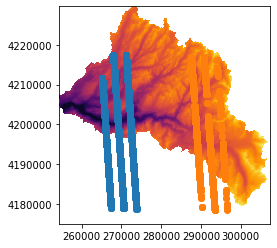

In [15]:
#plot DEM and overlapping ATL06 lines
%matplotlib inline
import matplotlib.pyplot as plt 
fig,ax = plt.subplots()
im = ax.imshow(dem,cmap='inferno',extent=[xmin,xmax,ymin,ymax])
#ATL06_gdf_list[1].plot(ax=ax)
for gdf in ATL06_gdf_list:
    gdf.plot(ax=ax)

In [16]:
# separate flight tracks for line-by-line comparison
df1,df2,df3,df4,df5,df6 = [x for x_,x in ATL06_gdf_list[1].groupby(ATL06_gdf_list[1]['p_b'])] #pick 1 ATL06 and seperate it into 6
df_list = [df1,df2,df3,df4,df5,df6]

-18.504121913466342 252.78507603111265 -0.5508148715942514
0.38108416685124036 2.254291795882281 0.0394012211571492
54.621960826755796 210.40869082124325 1.5931456372062454
-2.1071135753721704 65.55715977971201 -0.09240064478711804
-573.6537426757812 988.188457663341 -17.52319653474577
-252.99052385602678 583.4285728236908 -7.37397841918064


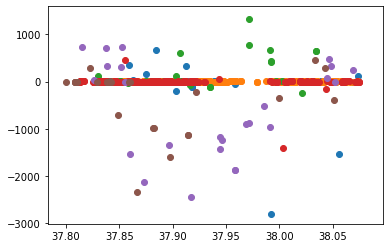

In [17]:
# comparison of ground data and ATL06 using a 20m buffer sampler
# colors represent the flight lines shown above
df_test_big = gda_lib.buffer_sampler(ds,big_gdf,20,ret_gdf=True)
df_test_big['snow_on_off'] = df_test_big['h_li']-df_test_big['med']

fig,ax = plt.subplots()
for gdf in df_list:
    df_test = gda_lib.buffer_sampler(ds,gdf,20,ret_gdf=True)
    df_test['snow_on_off'] = df_test['h_li']-df_test['med']
    ax.scatter(df_test['latitude'],df_test['snow_on_off'])
    print(df_test['snow_on_off'].mean(),df_test['snow_on_off'].std(),100*df_test['snow_on_off'].mean()/(df_test['h_li'].max()-df_test['h_li'].min()))
# df_test['snow_on_off'].hist(bins=30)
# ax.scatter(df_test['latitude'],df_test['snow_on_off'])

big_gdf['diff'] = df_test_big['snow_on_off']

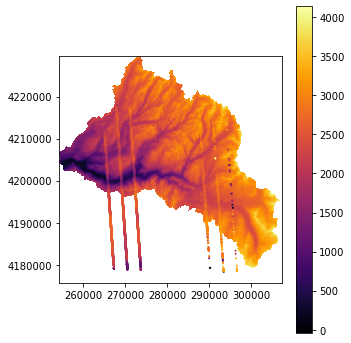

In [18]:
# point-by-point comparison
fig,ax = plt.subplots(figsize=(5,6))
im = ax.imshow(dem,cmap='inferno',extent=[xmin,xmax,ymin,ymax])
big_gdf.plot('h_li',legend=True,ax=ax,cmap='inferno',s=1)

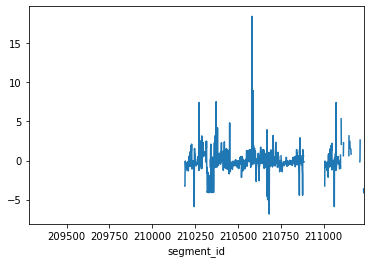

In [19]:
# example for grouping by segment id number
big_gdf.groupby('segment_id').median()['diff'].plot()

In [20]:
# process raster slope and aspect
!gdaldem slope $raster '/home/jovyan/data/slope.tif'
!gdaldem aspect $raster '/home/jovyan/data/aspect.tif'

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [21]:
# rasterio instance
ds2 = rasterio.open('/home/jovyan/data/slope.tif')
slp = ds2.read(1)
slp = np.ma.masked_equal(slp,gda_lib.get_ndv(ds2))
xmin,ymin,xmax,ymax = ds2.bounds
ds2.crs

ds3 = rasterio.open('/home/jovyan/data/aspect.tif')
asp = ds3.read(1)
asp = np.ma.masked_equal(asp,gda_lib.get_ndv(ds3))
xmin,ymin,xmax,ymax = ds3.bounds
ds3.crs

CRS.from_epsg(32611)

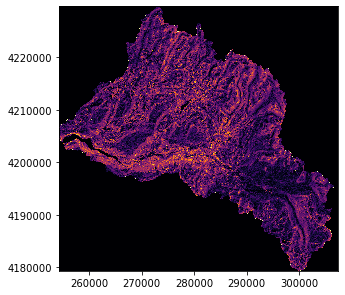

In [22]:
# visualize data
fig,ax = plt.subplots(figsize=(5,6))
im = ax.imshow(slp,cmap='inferno',extent=[xmin,xmax,ymin,ymax])

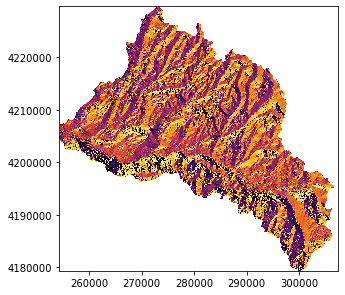

In [23]:
# visualize data
fig,ax = plt.subplots(figsize=(5,6))
im = ax.imshow(asp,cmap='inferno',extent=[xmin,xmax,ymin,ymax])

In [24]:
# sample data along same ground tracks
df_test_big_slp = gda_lib.buffer_sampler(ds2,big_gdf,20,ret_gdf=True)
good_idx = df_test_big['atl06_quality_summary']==0
df_test_big = df_test_big.loc[good_idx]

df_test_big_asp = gda_lib.buffer_sampler(ds3,big_gdf,20,ret_gdf=True)

Text(0.5, 0, 'Slope [deg]')

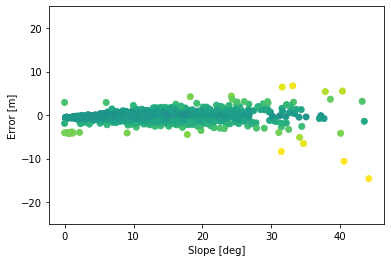

In [25]:
df_test_big_slp = df_test_big_slp.loc[good_idx]
fig,ax = plt.subplots()
ax.scatter(df_test_big_slp['med'],df_test_big['snow_on_off'],\
          c=abs(df_test_big['snow_on_off']),vmin=-7,vmax=7)
plt.ylim(-25,25)
plt.ylabel('Error [m]')
plt.xlabel('Slope [deg]')

/srv/conda/lib/python3.6/site-packages/windrose/windrose.py:29: MatplotlibDeprecationWarning: 
The Appender class was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  addendum = docstring.Appender(msg, "\n\n")
/srv/conda/lib/python3.6/site-packages/windrose/windrose.py:30: MatplotlibDeprecationWarning: 
The copy_dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use docstring.copy() and cbook.dedent() instead.
  return lambda func: addendum(docstring.copy_dedent(base)(func))
/srv/conda/lib/python3.6/site-packages/windrose/windrose.py:30: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.getdoc() instead.
  return lambda func: addendum(docstring.copy_dedent(base)(func))
/srv/conda/lib/python3.6/site-packages/windrose/windrose.py:30: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  retu

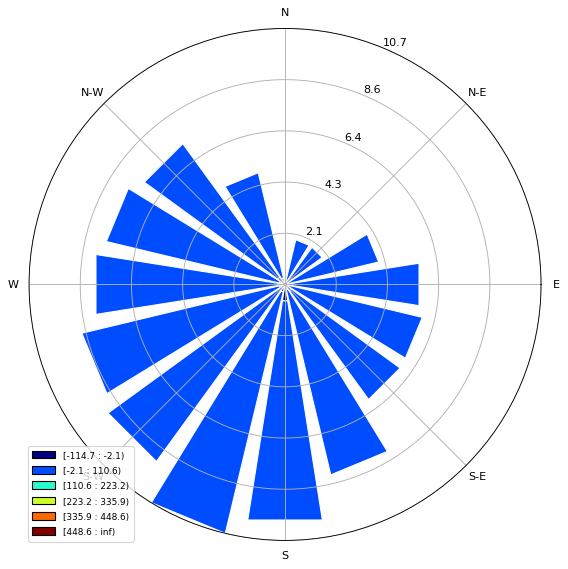

In [26]:
from windrose import WindroseAxes
import matplotlib.cm as cm
df_test_big_asp = df_test_big_asp.loc[good_idx]

ax = WindroseAxes.from_ax()
ax.bar(df_test_big_asp['med'],\
       df_test_big['snow_on_off'], normed=True,\
       opening=0.8, edgecolor='white');
ax.set_legend()